# SaO Assignment Solution 2

## Methodology

After reading given files, a set of lists and dataframes are created that will aid in solving this problem. These lists include list of depots, customers and customer which are compulsory customers. As per the problem statement, the customers whose current tank level is less than 15% of its total capacity are compulsory customers and fuel must be delivered to them to avoid a penalty of 1000 pounds. These customers are included in a list called cust_must. 
Distances between all depots are found to be greater than 250 miles. Thus any lorry that starts with one of the depots can never end its journey at another depots. It also means that every lorry has to return to the same depot, it started from. Moreover, if a lorry visits a customer which is more than 125 miles, can not return back to the depot without travelling a distance of more than 250 miles, which is not allowed. Thus nodes which are at a distance of 125 or less can be grouped into one clusters. And there are four such clusters formed for four depots.
These clusters are plotted with networkx library. In these graphs, Big red nodes indicate depot. Smaller red nodes indicate compulsory/must customers. Green nodes indicate optional customer whose current fuel level is greater than 15%. Blues nodes indicate normal nodes (neither customers nor depots). 
After this points the solution is obtained in two major steps. 
1. Generating all possible paths from depot to depot
2. Calculating final paths by rejecting invalid paths

#### 1. Generating all possible paths from depot to depot
For generating all possible paths in a cluster, three matrices are used
    1. Source matix : All lorries start from depots. It can go to any outgoing paths from depot and can find a customer. Source matrix consists of all the very first compolsory customers a lorry finds when it starts from a depot. For example, in the cluster of depot 523, all the compulsory customers 70, 276 and 391 fall on the same path. So source matrix will have only 70. So source matrix will be [[523,70]]
    2. Destination matrix : This matrix has all the paths that a lorry can take on its return journy to depot. A lorry may want to return to depot if going to another node is going to take more than 250 miles for entire journey or LPG in its tanker is over. For example in case  of cluster of depot 124, a lorry may want to return from 206 or 254 or 542. So the destination matrix is [[206, 36, 14, 124], [254, 36, 14, 124], [542, 124], [206, 124], [254, 124]]. 36 and 14 are the optional customers and lorry may or may not want to deliver them depending on availability of fuel. Hence there are options with or without them.
    3. Middle matrix :  This matrix joins the missing roads from end of source matrix to beginning of destination matrix. It considers all possible permutations. The first node is middle matrix is always one of the last nodes in source matrix. The last matrix in middle matrix is always one of the first nodes in destination matrix. 

Lastly using these three matrices , all possible paths can be listed.


#### 2. Calculating final paths by rejecting invalid paths
The paths generated in first step undergo multiple validation checks. A path is rejected if its longer than 250 miles, fuel required to deliver all the customers on path is greater than capacity of large tanker or if it is delivering to only one customer and cost of delivery is greater than 1000. If it is delivering to only one customer and cost of delivery is greater than 1000, then paying a penalty of 1000 is prefered to save cost.  



Note : This solution has delivered the amount fuel to customers so that their tanks are full and not the amount of fuel that will make their tanks 15% full of their total capacity. 

#### Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
from google.colab import drive
drive.mount('/content/gdrive')
from IPython.core.display import display, HTML
import os

Mounted at /content/gdrive


In [2]:
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

In [3]:
os.environ['PROJECT_PATH'] = '/content/gdrive/My Drive/Colab Notebooks/SAO/Project'

#### Drawing clusters

In [4]:
# Reading files
df_links = pd.read_csv(os.path.join(os.environ['PROJECT_PATH'],'SaO_Optilandia_links.csv'))
df_loc = pd.read_csv(os.path.join(os.environ['PROJECT_PATH'],'SaO_Optilandia_locations.csv'))
import json 
f = open(os.path.join(os.environ['PROJECT_PATH'],'SaO_Optilandia_depot_lorries.json')) 
lorries_dict = json.load(f) 
f.close() 

# A dataframe for all customers
df_cust=df_loc.loc[df_loc['is_customer'] == True]      
# A new column to show how much empty is the customer tank
df_cust['empty']=df_cust['capacity']-df_cust['level']
# A dataframe to get the customers who has current level less than 15% of its total capacity
df_cust_must=df_cust.loc[df_cust['level']<df_cust['capacity']*0.15]

# List of all depots
depoList=df_loc.loc[df_loc['is_depot'] == True]['id'].tolist()
#list of all customers
custList=df_loc.loc[df_loc['is_customer'] == True]['id'].tolist()
# list of all customers to whome we should deliver fuel to avoid penalty 
cust_must=df_cust_must["id"].tolist()
#Euclidean distance from all nodes to all nodes 
dist_eucl = squareform(pdist(df_loc[['x','y']].values, 'euclidean'))
#list of tupples with id of source and destination node and distance between them
edges  = [(id1,id2,dist_eucl[id1,id2]) for _,(id1,id2) in df_links.iterrows()]
# temporary column for list of zipped x and y coordinates 
df_loc['new_col'] = list(zip(df_loc.x, df_loc.y))
# zip that new column with corresponding id
posDict=dict(zip(df_loc.id,df_loc.new_col))
del df_loc['new_col']

# https://stackoverflow.com/questions/33863550/how-to-specify-edge-length-in-networkx-for-calculating-shortest-distance
G = nx.Graph()
for start, end, length in edges:
    G.add_edge(start, end, length=length)     # add edges to the graph
#nx.shortest_path_length(G, 116, 373, weight='length')

In [5]:
#Distances between depots
print(nx.shortest_path_length(G,source=116,target=124,weight='length'))
print(nx.shortest_path_length(G,source=116,target=373,weight='length'))
print(nx.shortest_path_length(G,source=116,target=523,weight='length'))
print(nx.shortest_path_length(G,source=124,target=373,weight='length'))
print(nx.shortest_path_length(G,source=124,target=523,weight='length'))
print(nx.shortest_path_length(G,source=373,target=523,weight='length'))

426.02776996580656
397.1380815592918
252.3919422324179
419.4536821256509
628.2079910103396
319.1454759553961


**Observations :** 
1. All the distances between depots are greater than 250 miles
2. So a lorry that starts from one depot can not reach another depot within 250 miles
3. So every lorry that starts with one depot has to return to the same depot
5. So its better to divide the network into four clusters
6. A lorry can not travel Any node which is more than 125 miles away from its depot
7. Otherwise it wont be able to reach back to the depot without travelling more than 250 miles
8. So nodes which are less than 125 miles away from depot can be grouped into one cluster 

In [6]:
# Lists that contain nodes in respective clusters
D116=[]
D124=[]
D373=[]
D523=[]
for c in df_loc['id']:
    d1=nx.shortest_path_length(G,source=116,target=c,weight='length')
#distances of nodes from depots
    d2=nx.shortest_path_length(G,source=124,target=c,weight='length')
    d3=nx.shortest_path_length(G,source=373,target=c,weight='length')
    d4=nx.shortest_path_length(G,source=523,target=c,weight='length')
# if the node is less than 125 miles away from depot, add it to its cluster
    if d1<=125.0:
        D116.append(c)
    if d2<=125.0:
        D124.append(c)
    if d3<=125.0:
        D373.append(c)
    if d4<=125.0:
        D523.append(c)

**Notes :** 
1. Reading files
2. Dataframe and lists are created that will help in further processing
3. Create a dataframe for all customers, a new column to show how much empty is the customer tank, a dataframe to get the customers who has current level less than 15% of its total capacity, List of all depots, list of all customers.
4. Create a square matrix for Euclidean distance from all nodes to all nodes 
5. Create a list of tupples with id of source and destination node and distance between them
6. Create a dictionary for id of nodes with tupple of location
7. a new column called 'new_col' is created to aid this process. it is deleted later.
8. A graph is created for entire network.
9. All nodes that are within 125 miles from a depot are added to its cluster

#### Displaying subgraphs for every cluster

In [7]:
def dispGraph(G1,D,depo,posDict,cust_must,custList):
    posDict=dict((k, posDict[k]) for k in D)

    plt.figure(figsize=(20,10))
# blues nodes (neither customers nor depots )
    nx.draw(G1,with_labels=True,pos=posDict,node_color='b',node_size=1000,alpha=1)
# green nodes which are customers but not compulsory
    nx.draw_networkx_nodes(G1,posDict,nodelist=custList,node_color='g',node_size=1000,alpha=1);
# red nodes which are customers and compulsory
    nx.draw_networkx_nodes(G1,posDict,nodelist=cust_must,node_color='r',node_size=1000,alpha=1);
# Depots in red
    nx.draw_networkx_nodes(G1,pos=posDict,nodelist=[depo],node_color='r',node_size=2000,alpha=1);


**Notes :** 
1. Function to display networkx graphs
2. Different colors and sizes for different types of nodes

In [8]:
#variable names for depots
depo116=116
depo124=124
depo373=373
depo523=523

In [9]:
# subgraphs from each depots
G116 = G.subgraph(D116)
G124 = G.subgraph(D124)
G373 = G.subgraph(D373)
G523 = G.subgraph(D523)


In [10]:
#cust_must - compulsory cutomers in clusters
#custList - all cutomers in clusters
cust_must116 = [k for k in cust_must if k in D116]
custList116 = [k for k in custList if k in D116]
cust_must124 = [k for k in cust_must if k in D124]
custList124 = [k for k in custList if k in D124]
cust_must373 = [k for k in cust_must if k in D373]
custList373 = [k for k in custList if k in D373]
cust_must523 = [k for k in cust_must if k in D523]
custList523 = [k for k in custList if k in D523]

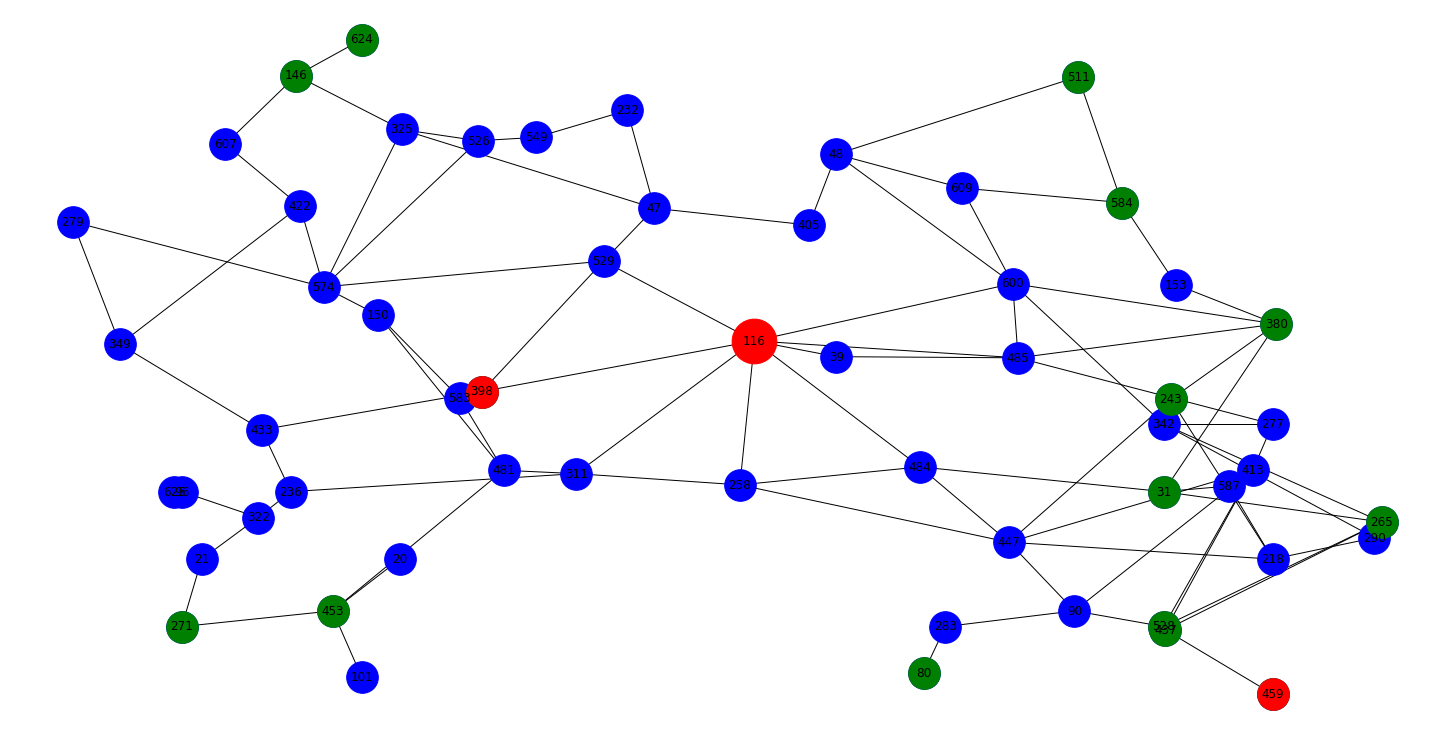

In [11]:
# plot graph for cluster of 116
dispGraph(G116,D116,depo116,posDict,cust_must116,custList116)

**Notes :** 
1. Subgraph for cluster of depot 116
2. Big red indicates depot
3. Smaller red indicates compulsory/must customers
4. Green indicates optional customers whose current fuel level is greater than 15%
5. blues nodes (neither customers nor depots )

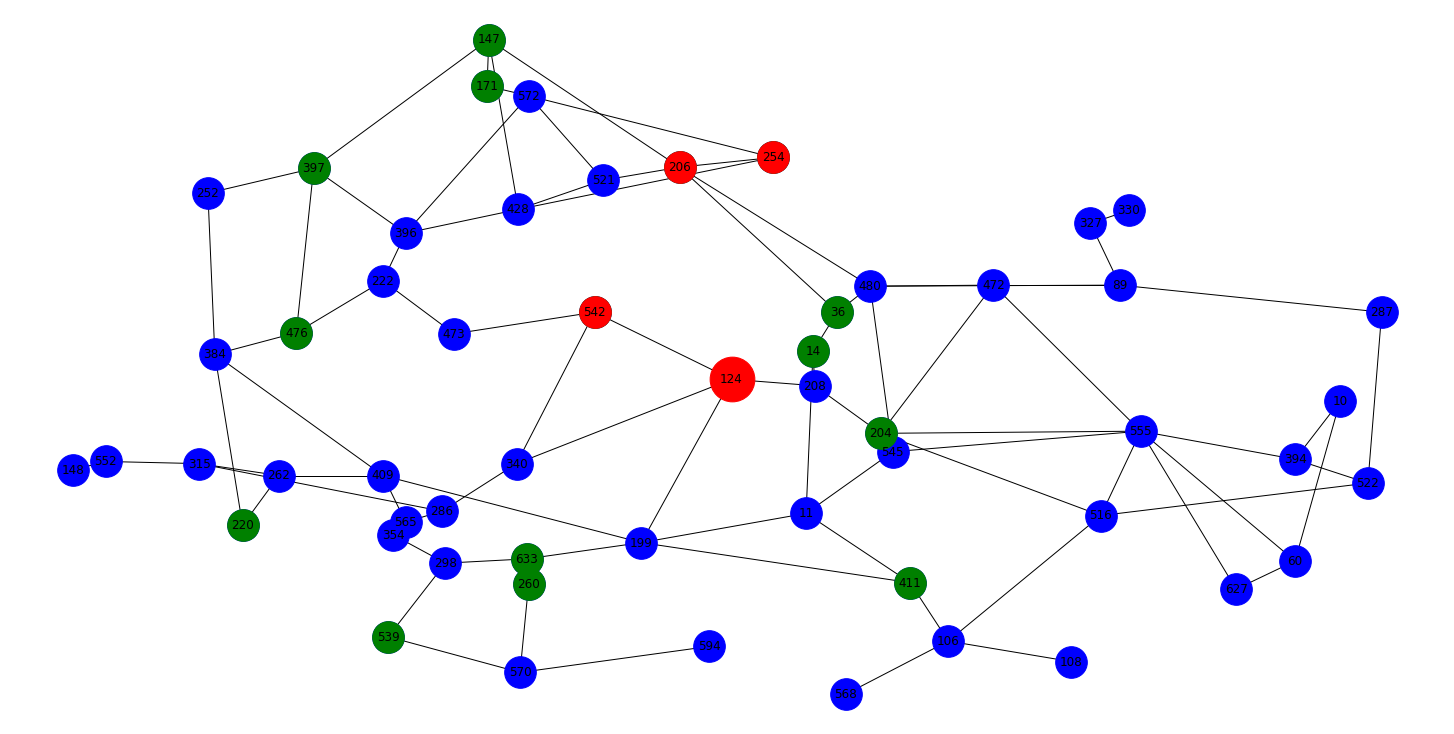

In [12]:
# plot graph for cluster of 124
dispGraph(G124,D124,depo124,posDict,cust_must124,custList124)

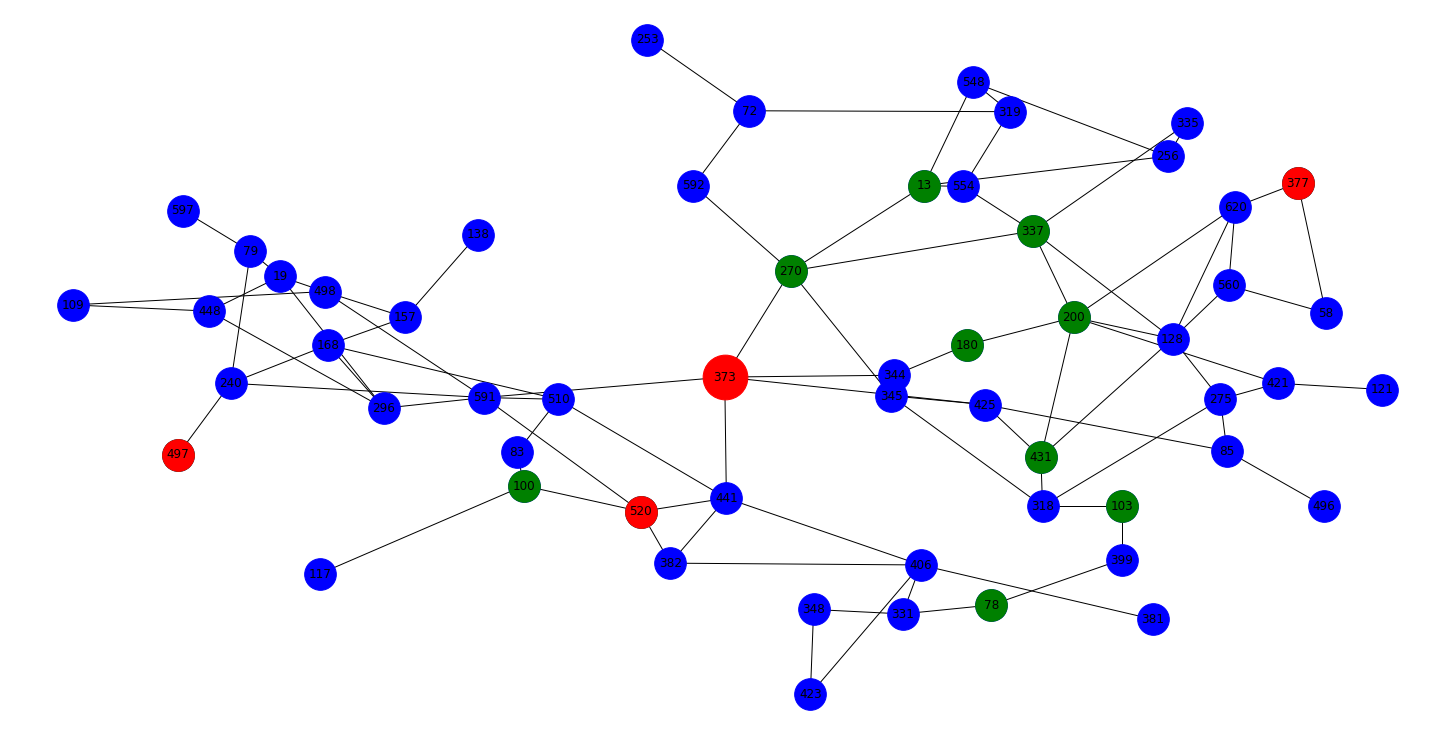

In [13]:
# plot graph for cluster of 373
dispGraph(G373,D373,depo373,posDict,cust_must373,custList373)

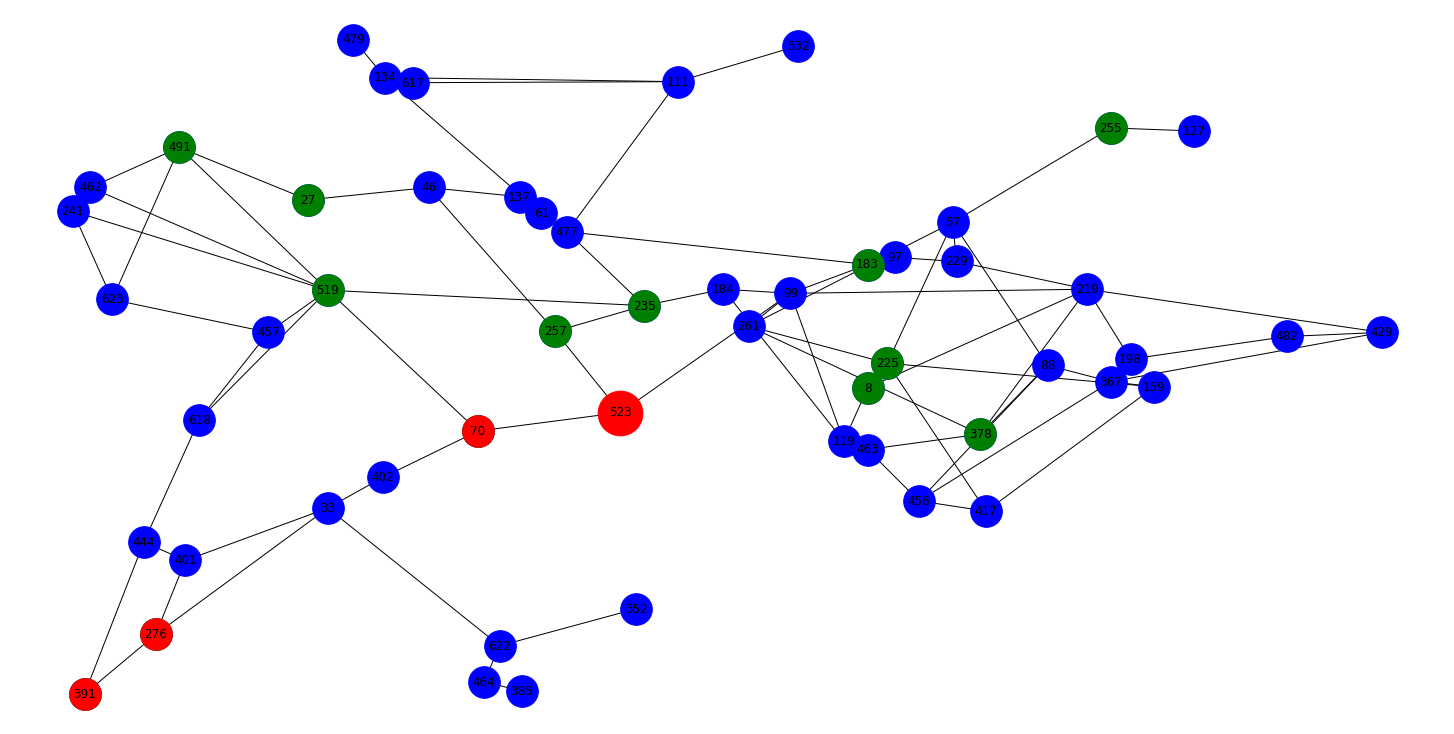

In [14]:
# plot graph for cluster of 523
dispGraph(G523,D523,depo523,posDict,cust_must523,custList523)

#### Creating all possible paths in every cluster

In [15]:
# create a source matrix
def source(G,d,c,custList):
    sourceMat=[]
    for i in c:
        sourceMat.append([d,i])    # first node is always going to be a depot
    last=[l[-1] for l in sourceMat]  # all last nodes in source
    for k in range(len(last)):
        l=len([value for value in last if value in nx.shortest_path(G,source=d,target=last[k],weight='length')[1:-1]])
        if l>0:
            del sourceMat[1]
# add to source matrix if it is in customer list and is the first customer in the path
    for i in range(len(sourceMat)):
        sourceMat[i]=[d]+[value for value in nx.shortest_path(G,source=sourceMat[i][0],target=sourceMat[i][1],weight='length') if value in custList]    
    return sourceMat

**Notes :** 
1. The source matrix consists of all the posible start of the path that a lorry can take
2. The first node in this matrix is always a depo
3. after starting from depot the first compulsory customer lorry can visit is included
4. On the way to a must customer, if it finds any optional customeres, then it is also included in source matrix

In [16]:
# Source matrix for depot 116
sourceMat116=source(G116,depo116,cust_must116,custList116)
sourceMat116

[[116, 398], [116, 528, 437, 459]]

**Notes :** 
1. In [116, 398] 116 is depo and 398 is the first compulsory customer on on of the paths
2. In [116, 528, 437, 459] 116 is depot. 459 is must customer. 528 and 437 are optional customers.

In [17]:
# Source matrix for depot 124
sourceMat124=source(G124,depo124,cust_must124,custList124)
sourceMat124

[[124, 14, 36, 206], [124, 542]]

**Notes :** 
1. In [124, 542], 124 is depo and 542 is the first compulsory customer on on of the paths
2. In [124, 14, 36, 206], 124 is depot. 206 is compulsory customer. 14 and 36 are optional customers.

In [18]:
# Source matrix for depot 373
sourceMat373=source(G373,depo373,cust_must373,custList373)
sourceMat373

[[373, 180, 200, 377], [373, 497], [373, 520]]

In [19]:
# Source matrix for depot 523
sourceMat523=source(G523,depo523,cust_must523,custList523)
sourceMat523

[[523, 70]]

In [20]:
def destination(G,d,c):
    destMat=[]
    for cust in c:
        pTemp=nx.shortest_path(G,source=cust,target=d,weight='length')[1:-1]
        # add if there are no other compulsory customers in path
        pTemp=[i for i in pTemp if i not in c] 
        # add if its a customer
        pTemp=[i for i in pTemp if i in custList]  
        # attach customer and depot
        pTemp=[cust]+pTemp+[d]                    
        destMat.append(pTemp)
    for i in range(len(destMat)):
        if len(destMat[i])>2:
            # for longer paths better to go directly to depot
            destMat.append([destMat[i][0]]+[destMat[i][-1]]) 
    return destMat

**Notes :** 
1. The destination matrix consists of all the posible ends of the path that a lorry can have
2. The last node in this matrix is always a depot
3. A lorry can be at any customer location and it may want to return to depot from there. 
4. this matrix has return path from all customer locations in a cluster
4. On the way to a compulsory customer, if it finds any optional customeres, then it is also included in source matrix

In [21]:
# destination matrix for depot 116
destMat116=destination(G116,depo116,cust_must116)
destMat116

[[398, 116], [459, 437, 528, 116], [459, 116]]

**Notes :** 
1. In [398, 116] and [459, 116] , 116 is depot
2. 398 and 459 are the customer nodes from where lorry wants to return in case if its fuel is over or it fears exceeding 250 miles before reaching depot.
2. In [459, 437, 528, 116], 116 is depot. 459 is compulsory customer. 437 and 528 are optional customers.

In [22]:
# destination matrix for depot 124
destMat124=destination(G124,depo124,cust_must124)
destMat124

[[206, 36, 14, 124], [254, 36, 14, 124], [542, 124], [206, 124], [254, 124]]

In [23]:
# destination matrix for depot 373
destMat373=destination(G373,depo373,cust_must373)
destMat373

[[377, 200, 180, 373], [497, 373], [520, 373], [377, 373]]

In [24]:
# destination matrix for depot 523
destMat523=destination(G523,depo523,cust_must523)
destMat523

[[70, 523], [276, 523], [391, 523]]

In [25]:
from itertools import permutations  
def middle(G,d,sourceMat,destMat,c):
    middleMat=[]
    L=[l[-1] for l in sourceMat]   # Last nodes in source matrix
    F=[l[0] for l in destMat]      # First nodes in destination matrix
    F=list(set(F))                 # Unique nodes in Fi
    for i in L:
        for j in F:
            if i != j:             # create a link if first and last are different
                p=nx.shortest_path(G,source=i,target=j,weight='length')
                middleMat.append([value for value in p if value in c])
    if len(c)>len(L):
        if len(L) != 1:
            middleMat.append([L[0]]+[v for v in c if v not in [L[0],L[-1]]  ]+[L[-1]])
            middleMat.append([L[-1]]+[v for v in c if v not in [L[0],L[-1]]  ]+[L[0]] )
    # Trying all permutions to create middle matrix
    if len(L)==len(c):
        p = permutations(L, 3)
        for j in p:
            middleMat.append(list(j))
    return middleMat

**Notes :** 
1. The source matrix provides all possibile starts of a journey and the destination matrix provides possibile ends of a journey.
2. The middle matrix provides all possible paths to go from end of source matrix to start of destination matrix
3. The first node in middle matrix is always a last naode in source matrix. The last node in middle matrix is always a first node in destination matrix.
4. It includes all possible permutations
5. On the way to a compulsory customer, if it finds any optional customeres, then it is also included in middle matrix

In [26]:
# create middle matrix for depot 116
middleMat116=middle(G116,depo116,sourceMat116,destMat116,cust_must116)
middleMat116

[[398, 459], [459, 398]]

**Notes :** 
1. 398 and 459 are last nodes in source matrix as well as first nodes in destination matrix

In [27]:
# create middle matrix for depot 124
middleMat124=middle(G124,depo124,sourceMat124,destMat124,cust_must124)
middleMat124

[[206, 542],
 [206, 254],
 [542, 206],
 [542, 254],
 [206, 254, 542],
 [542, 254, 206]]

In [28]:
# create middle matrix for depot 373
middleMat373=middle(G373,depo373,sourceMat373,destMat373,cust_must373)
middleMat373

[[377, 520],
 [377, 497],
 [497, 520],
 [497, 377],
 [520, 377],
 [520, 497],
 [377, 497, 520],
 [377, 520, 497],
 [497, 377, 520],
 [497, 520, 377],
 [520, 377, 497],
 [520, 497, 377]]

In [29]:
# create middle matrix for depot 523
middleMat523=middle(G523,depo523,sourceMat523,destMat523,cust_must523)
middleMat523

[[70, 276], [70, 276, 391]]

In [30]:
# creating all possible paths that cover customers using source, middle and destination matrix
def getPath(SM,MM,DM):
    allPaths=[]
    allPaths2=[]
    for i in SM:
        sourceL=i[-1]             # last node in source matrix
        for j in MM:
            if j[0]==sourceL:     # connect if same node is in first position of middle matrix
                destF=j[-1]       # first node in destination matrix
                for k in DM:
                    # connect if same node is in first position of destination matrix
                    if k[0]==destF:
                        allPaths.append(i+j[1:-1]+k)  # join them all to form final path
    # connect from source to destination directly
    for i in SM:
        sourceL=i[-1]
        for k in DM:
            if k[0]==sourceL:
                allPaths.append(i+k[1:])
    
    # keep unique values inside sublist
    for i in allPaths:
        unique_list = [] 
        for j in i:
            if j not in unique_list:
                unique_list.append(j)
        allPaths2.append(unique_list+[i[-1]])

    # to keep unique list of lists
    allPaths2 = [list(x) for x in set(tuple(x) for x in allPaths2)]
    return allPaths2

**Notes :** 
1. All possible combinations of rows in source, middle and destination matrix give all possible paths in the cluster.
2. A path is formed when the last node in source matrix is same as first node in middle matrix and last node in middle matrix is same as first node in destination matrix.
3. It is made sure that a path do not repeat any
4. But the first and last node of a path is always the depot

In [31]:
# get all possible paths in cluster of depot 116
paths116=getPath(sourceMat116, middleMat116,destMat116)
paths116

[[116, 398, 459, 437, 528, 116],
 [116, 398, 459, 116],
 [116, 398, 116],
 [116, 528, 437, 459, 398, 116],
 [116, 528, 437, 459, 116]]

**Notes :** 
1. The function takes source, middle and destination matrix as input
2. This path just possible path and do not necessarily follow all conditions.

In [32]:
# get all possible paths in cluster of depot 124
paths124=getPath(sourceMat124, middleMat124,destMat124)
paths124

[[124, 542, 254, 206, 36, 14, 124],
 [124, 542, 254, 36, 14, 124],
 [124, 542, 206, 124],
 [124, 14, 36, 206, 124],
 [124, 14, 36, 206, 542, 124],
 [124, 14, 36, 206, 254, 124],
 [124, 542, 254, 206, 124],
 [124, 542, 206, 36, 14, 124],
 [124, 542, 254, 124],
 [124, 542, 124],
 [124, 14, 36, 206, 254, 542, 124]]

In [33]:
# get all possible paths in cluster of depot 373
paths373=getPath(sourceMat373, middleMat373,destMat373)
paths373

[[373, 180, 200, 377, 520, 373],
 [373, 497, 377, 520, 373],
 [373, 497, 373],
 [373, 180, 200, 377, 520, 497, 373],
 [373, 497, 377, 373],
 [373, 180, 200, 377, 497, 520, 373],
 [373, 520, 497, 377, 200, 180, 373],
 [373, 520, 497, 377, 373],
 [373, 497, 520, 377, 373],
 [373, 520, 377, 200, 180, 373],
 [373, 520, 373],
 [373, 497, 520, 373],
 [373, 497, 520, 377, 200, 180, 373],
 [373, 520, 497, 373],
 [373, 180, 200, 377, 373],
 [373, 520, 377, 497, 373],
 [373, 520, 377, 373],
 [373, 497, 377, 200, 180, 373],
 [373, 180, 200, 377, 497, 373]]

In [34]:
# get all possible paths in cluster of depot 523
paths523=getPath(sourceMat523, middleMat523,destMat523)
paths523

[[523, 70, 523], [523, 70, 276, 391, 523], [523, 70, 276, 523]]

## Validate paths 

In [35]:
#calculate total path length when all nodes in path are passed as list
def path_length(path2):
    sum=0
    for k in range(len(path2)-1):
        sum = sum + dist_eucl[path2[k]][path2[k+1]]
    return sum

**Notes :** 
1. The function calculates path lenght given the path as input
2. It considers Euclidean distances for calculations

In [36]:
#calculate total path length considering shortest path between 
#customer nodes when list of customer nodes are passed
def cust_path_length(path2,G):
    sum=0
    for k in range(len(path2)-1):
        sum = sum + nx.shortest_path_length(G, path2[k], path2[k+1], weight='length')
    return sum


**Notes :** 
1. The function calculate total path length considering shortest path between customer nodes when list of customer nodes are passed.

In [37]:
# Compute cost per mile per ton (cpmpt)
# L is current fuel level
# c is list of customers in path
def Compute_cpmpt(G,cpmpt,c,L):
    cpmpt_path=0
    for i in range(len(c[:-1])):
        dist=nx.shortest_path_length(G, c[i], c[i+1], weight='length')  # get the distance
        cpmpt_path=cpmpt_path+(dist*L)              # multiply distance by current fuel level
        if i != len(c[:-1])-1:
            e=df_cust.loc[df_cust['id']==c[i+1]]['empty'].values[0]   # empty amount in litres
            L=L-e                                 # subtract delivered fuel from current level
    return cpmpt_path,L

**Notes :** 
1. The function calculates Compute cost per mile per ton (cpmpt).
2. After every customer delivered fuel is subtract from current level

In [38]:
# Compute final cost given a path
# G- graph
# d- depot id
# c- list of customers
# L- Current level of fuel in lorry 
def Compute_cost(G,d,c,L):
# if lorry capacity is 5 them cost per mile is 1 and cost per mile per ton is 1.5
    if L==5:
        cpm=1
        cpmpt=1.5
# if lorry capacity is 12 them cost per mile is 1.5 and cost per mile per ton is 1
    if L==12:
        cpm=1.5
        cpmpt=1
# if lorry capacity is 22 them cost per mile is 2 and cost per mile per ton is 0.5
    if L==22:
        cpm=2
        cpmpt=0.5
    PL=cust_path_length(c,G)   # PL is path length obtained with a function
    cpm_path=PL*cpm            # multiply path length with cost per mile
    cpmpt_path,L=Compute_cpmpt(G,cpmpt,c,L)     # get cost pe mile per ton
    return PL,cpm_path+cpmpt_path,L    

**Notes :** 
1. The function calculates total cost.
2. It is combination of cost per mile(cpm) and cost per mile per ton (cpmpt)

In [39]:
# Check if the paths are valid
def validatePaths(G,paths,d,capacity,finalPath):
    #find the length of longest valid paths
    longest=0
    for i in paths:
        if i not in finalPath:
            path_L,cost,fuel_left=Compute_cost(G,d,i,capacity)
            if path_L<=250.0 and fuel_left>=0:
                if len(i)>longest:
                    longest=len(i)
    c=10000  # cost ( initial assumption which will be minimised in code)
    final=[]
    for i in paths:
        path_L,cost,fuel_left=Compute_cost(G,d,i,capacity)
        # if path length is less than 250 and fuel is enough
        if path_L<=250.0 and fuel_left>=0:    
            if len(i)==longest:    # path with longest length
                if i not in finalPath:
                    if cost<c:
                        final=i     # make it the final path
                        c=cost
    return final

**Notes :** 
1. The function validates the paths calculated in first part of code.
2. a path is rejected if it takes more than 250 miles or it requires more fuel than available
3. It prefers the longest path so that more customers can be covers with minimum cost.

In [40]:
# Finalising the paths by checking for necessary conditions
def computeFinalPaths(cust_must,G,paths,depo):
    finalPath=[]
    for x in range(len(cust_must)):
        finalPath.append(validatePaths(G,paths,depo,5,finalPath)) # validation
        # flat list of all customers in final path
        flat_list = [item for sublist in finalPath for item in sublist]
        if(set(cust_must).issubset(set(flat_list))):
            break                  
    for i in finalPath:
        path_L,cost,fuel_left=Compute_cost(G,depo,i,5)   # Compute  cost  of the path
        if cost>1000.0:                                  # remove cost is greater than 1000
            if len(set(cust_must)&set(i))==1:
                finalPath.remove(i)
    print("The final path is ",finalPath) 
    return finalPath

**Notes :** 
1. It calls another function to compute the cost
2. Calls validate function to reject invalid paths
3. If the cost of path is greater than 1000 and if it covers only one compulsory node, then it skips that compulsory node and prefers to pay a penalty of 1000 pounds

## Calculate Final paths 

In [41]:
# Final paths for cluter of depot 116
finalPath116 = computeFinalPaths(cust_must116,G116,paths116,depo116)

The final path is  [[116, 398, 116]]


In [42]:
# Final paths for cluter of depot 124
finalPath124 = computeFinalPaths(cust_must124,G124,paths124,depo124)

The final path is  [[124, 14, 36, 206, 254, 542, 124]]


In [43]:
# Final paths for cluter of depot 373
finalPath373 = computeFinalPaths(cust_must373,G373,paths373,depo373)

The final path is  [[373, 520, 373]]


In [44]:
# Final paths for cluter of depot 523
finalPath523 = computeFinalPaths(cust_must523,G523,paths523,depo523)

The final path is  [[523, 70, 276, 391, 523]]


**Observations :** 
1. Final paths are calculted.
2. There are only four paths. One per cluster.
3. Only 10 customers are delivered fuel in all four clusters.
4. Out of 10, two nodes are optional and 8 are compulsory

### Creating JSON

In [45]:
#Added from here
df_chosencust=df_cust[df_cust['id'].isin([398,14,36,206,254,542,520,70,276,391])]

In [46]:
df_chosencust

,id,x,y,is_depot,is_customer,capacity,level,empty
14,14,49968.8889,5931.9444,False,True,1.0,0.67,0.33
36,36,49972.7778,5941.9444,False,True,1.0,0.19,0.81
70,70,49561.9444,6221.6667,False,True,1.5,0.04,1.46
206,206,49947.5000,5979.1667,False,True,1.0,0.12,0.88
254,254,49962.5000,5981.6667,False,True,1.5,0.22,1.28
276,276,49516.6667,6166.6667,False,True,1.0,0.07,0.93
391,391,49506.6667,6150.5556,False,True,1.0,0.00,1.00
398,398,49762.5000,6241.3889,False,True,1.0,0.11,0.89
520,520,49602.2222,5948.3333,False,True,0.5,0.06,0.44
542,542,49933.8889,5941.9444,False,True,0.5,0.03,0.47


In [47]:

from itertools import chain 
finalPath124= list(chain.from_iterable(finalPath124))
print(finalPath124)

finalPath116= list(chain.from_iterable(finalPath116))
print(finalPath116)

finalPath373= list(chain.from_iterable(finalPath373))
print(finalPath373)

finalPath523= list(chain.from_iterable(finalPath523))
print(finalPath523)

[124, 14, 36, 206, 254, 542, 124]
[116, 398, 116]
[373, 520, 373]
[523, 70, 276, 391, 523]


In [48]:
def printResult(depot, finalPath):
  result=[]
  lorry_id=lorries_dict[str(depot)][0]['lorry_id']
  fuelLoaded=df_chosencust[df_chosencust['id'].isin(finalPath)]['empty'].sum()
  loc=[]
  for i, node in enumerate(finalPath):
    if (node==depot and i==0):
      loc.append([node, fuelLoaded])
    elif (node==depot and i!=0 ):
      loc.append([node, 0])
    else:
      fuelDelivered=df_chosencust[df_chosencust['id']==node]['empty'].item()
      loc.append([node, -fuelDelivered])
  result.append({'lorry_id': lorry_id, 'loc': loc})
  return result


In [49]:
result116=printResult(116, finalPath116)
result124=printResult(124, finalPath124)
result373=printResult(373, finalPath373)
result523=printResult(523, finalPath523)
result=[]
result.extend(result116)
result.extend(result124)
result.extend(result373)
result.extend(result523)
sresult=json.dumps(result)
print(sresult)

[{"lorry_id": "116-0", "loc": [[116, 0.89], [398, -0.89], [116, 0]]}, {"lorry_id": "124-0", "loc": [[124, 3.7699999999999996], [14, -0.32999999999999996], [36, -0.81], [206, -0.88], [254, -1.28], [542, -0.47], [124, 0]]}, {"lorry_id": "373-0", "loc": [[373, 0.44], [520, -0.44], [373, 0]]}, {"lorry_id": "523-0", "loc": [[523, 3.3899999999999997], [70, -1.46], [276, -0.9299999999999999], [391, -1.0], [523, 0]]}]


In [50]:
with open(os.path.join(os.environ['PROJECT_PATH'], '7_sao_soln2.json'), 'w') as outfile:
  json.dump(result, outfile)
  #Added till here

## Conclusion
The capacited multivehical problems are interesting but very complex and pose an increasing challenge if the complexity of network increases. Networkx helps a lot in visualising the problem and making strategies for solution. Using the concept of source, middle and destination matrix makes it easy to form paths. Our aim to implement as much as possible from scratch makes it more challenging. All the constraints in this problem statement help in rejecting many nodes and paths and makes it easy to solve.